

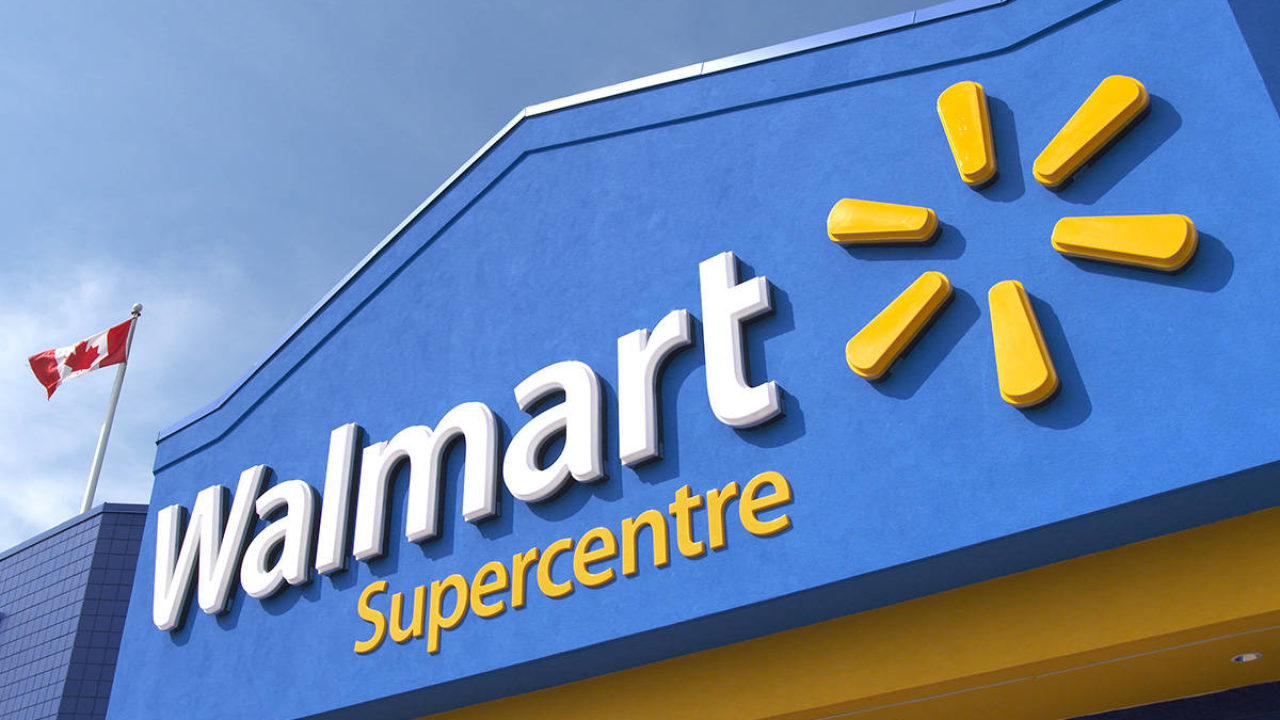

In [7]:
!pip install category_encoders
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import PolynomialFeatures
from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.1 MB/s eta 0:00:00


Data import

In [8]:
df = pd.read_csv('Walmart.csv', sep=',', parse_dates=['Date'], dayfirst=True)

In [9]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [10]:
df.columns = df.columns.str.lower()

In [11]:
df.info() # check the accuracy of data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store         6435 non-null   int64         
 1   date          6435 non-null   datetime64[ns]
 2   weekly_sales  6435 non-null   float64       
 3   holiday_flag  6435 non-null   int64         
 4   temperature   6435 non-null   float64       
 5   fuel_price    6435 non-null   float64       
 6   cpi           6435 non-null   float64       
 7   unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


**We have the next fields in our dataset:**

store - the store number

date - the week of sales 2010-02-05 to 2012-11-01

weekly_Sales - sales for the given store

holiday_flag - whether the week is a special holiday week 1 – Holiday week 0 –

temperature - Temperature on the day of sale

fuel_price - Cost of fuel in the region

cpi – Prevailing consumer price index

unemployment - Prevailing unemployment rate

In [12]:
df.head()

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


Data preparation

In [13]:
df.shape

(6435, 8)

In [14]:
df.isna().sum() # no missing values

store           0
date            0
weekly_sales    0
holiday_flag    0
temperature     0
fuel_price      0
cpi             0
unemployment    0
dtype: int64

In [15]:
df.duplicated().sum() # no evident dublicates

0

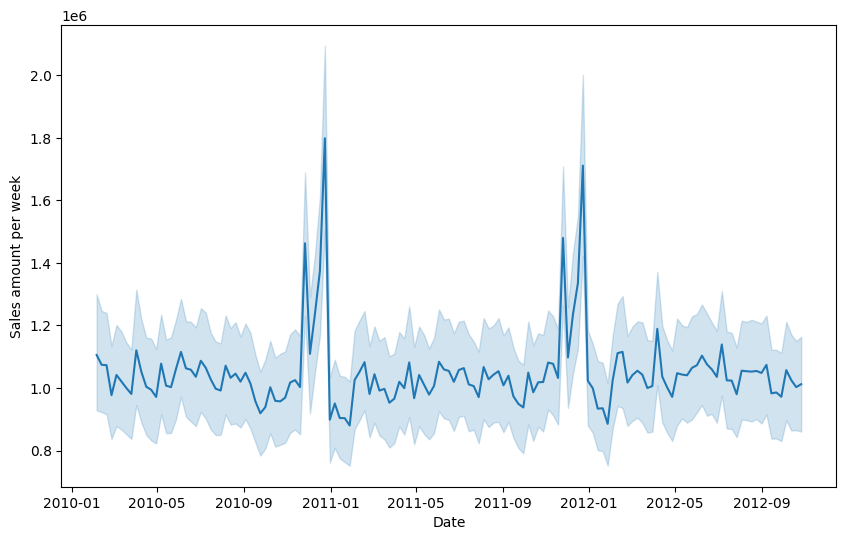

In [16]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='date', y='weekly_sales')
plt.xlabel('Date')
plt.ylabel('Sales amount per week')
plt.show()

We can notice seasonality in our data, especially at the end of December as consumers begin  actively purchasing for the holidays. In other periods we can say that the values are stationary and abrupt(скачкообразные)

In [17]:
# check distribution of numeric values
numeric = df[['temperature', 'fuel_price', 'cpi', 'unemployment']]
not_numeric = df[['store', 'holiday_flag', 'date']]

In [18]:
# unique values of stores
df['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

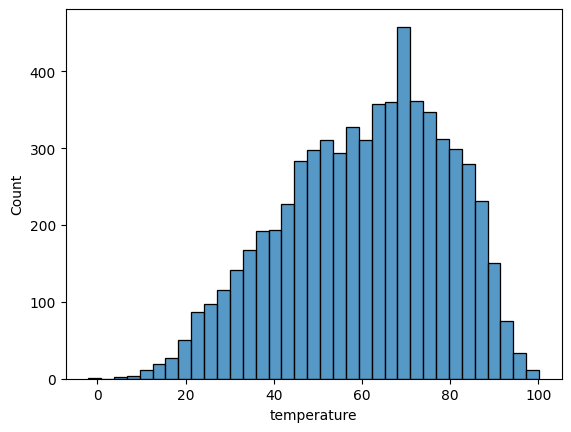

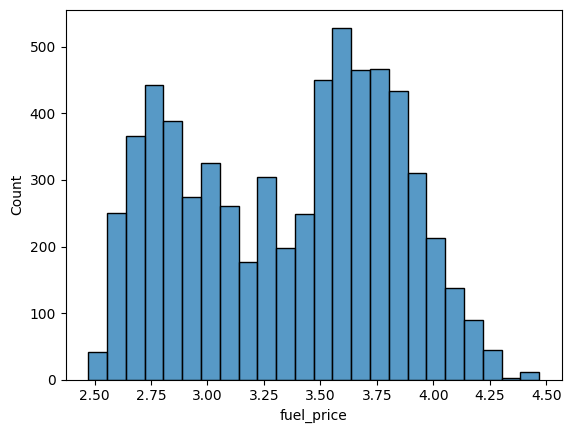

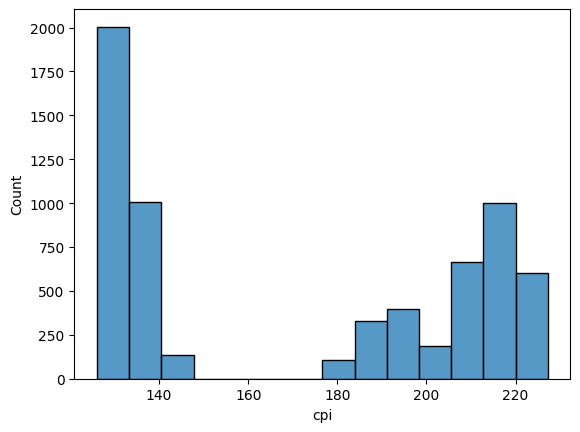

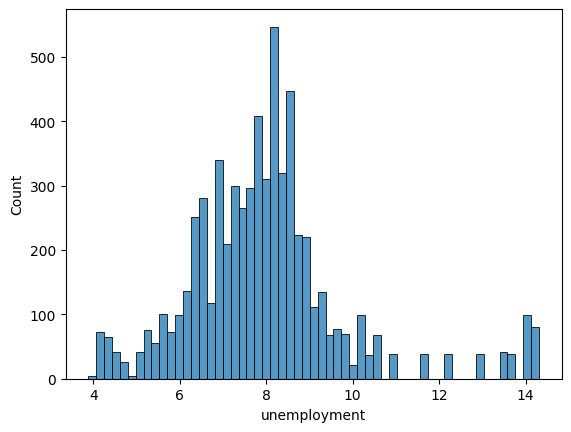

In [19]:
for i in numeric.columns:
  sns.histplot(df[i])
  plt.show()

It's clear that some of the features don't have normal distribution, some of them have more than 1 mode, i will get rid of outiers in that case

0 temperature
1 fuel_price
2 cpi
3 unemployment


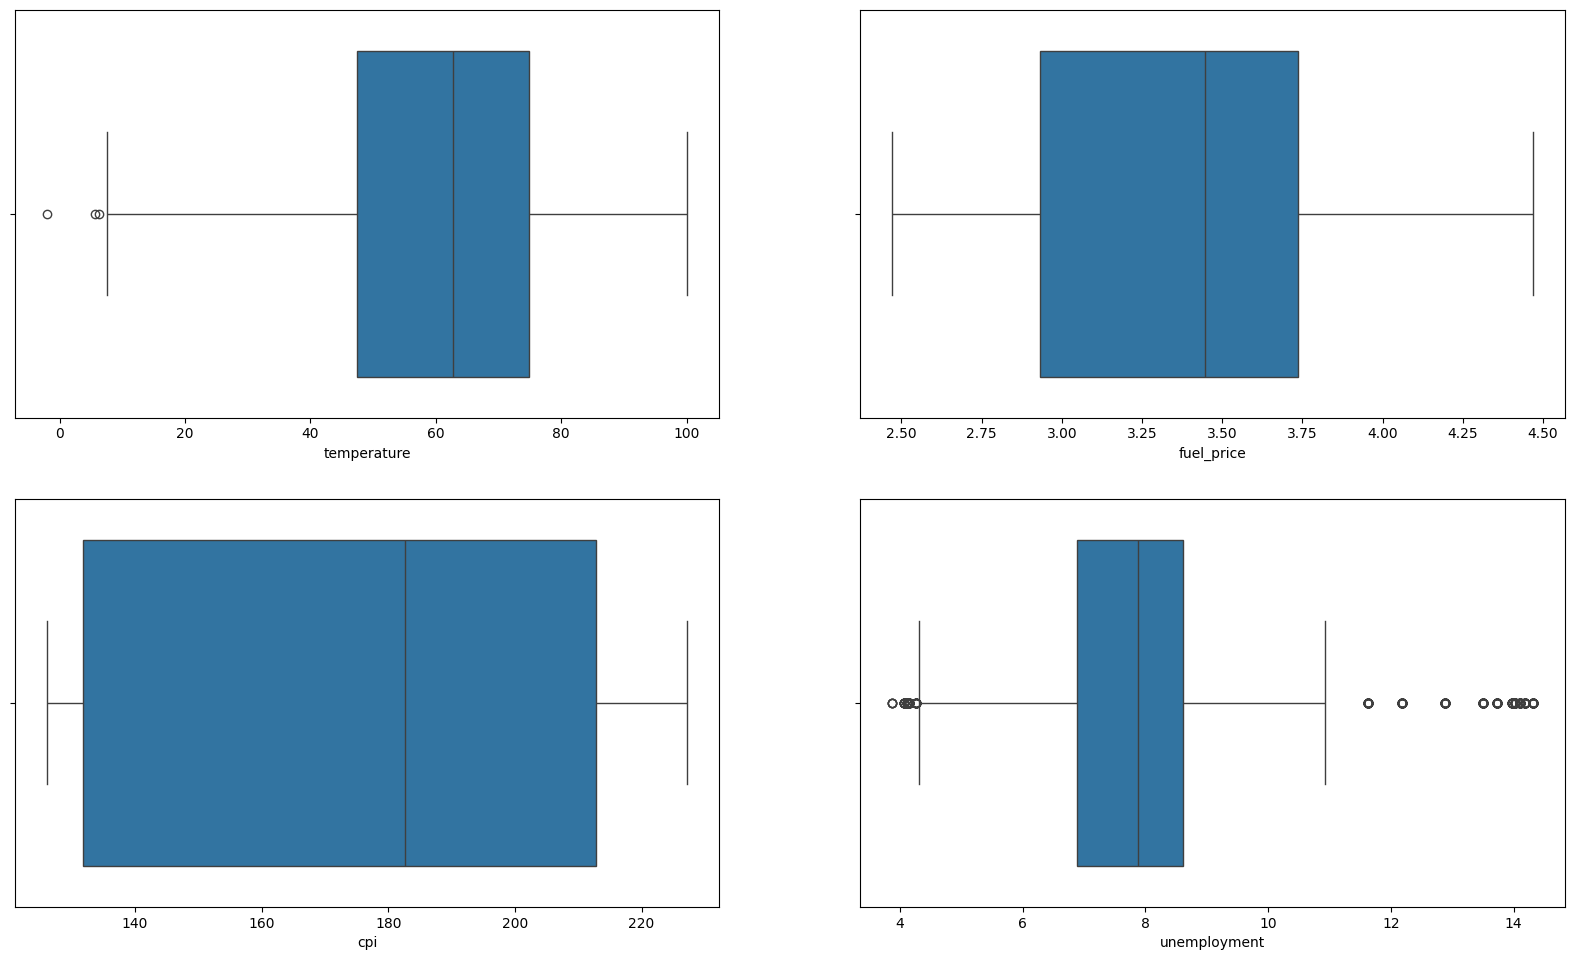

In [20]:
plt.figure(figsize=(20,18))
for i,col in enumerate(numeric):
    print(i, col)
    plt.subplot(3,2,i+1)
    sns.boxplot(df, x = col)
plt.show()

In [21]:
from scipy import stats as st

In [22]:
# let's remove outliers from 'temperature'
Q1 = df['temperature'].quantile(0.25)
Q3 = df['temperature'].quantile(0.75)
IQR = Q3 - Q1

filter = (df['temperature'] >= Q1 - 1.5 * IQR) & (df['temperature'] <= Q3 + 1.5 *IQR)
df = df.loc[filter]

In [23]:
# let's remove outliers from 'unemployment'
Q1 = df['unemployment'].quantile(0.25)
Q3 = df['unemployment'].quantile(0.75)
IQR = Q3 - Q1

filter = (df['unemployment'] >= Q1 - 1.5 * IQR) & (df['unemployment'] <= Q3 + 1.5 *IQR)
df = df.loc[filter]

In [24]:
df.describe()

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
count,5951.000000,5951,5.951000e+03,5951.000000,5951.000000,5951.000000,5951.000000,5951.000000
mean,22.744077,2011-06-14 12:49:43.565787392,1.051011e+06,0.070240,60.318278,3.339541,174.934816,7.720502
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,7.460000,2.472000,126.064000,4.308000
25%,11.000000,2010-10-08 00:00:00,5.540650e+05,0.000000,46.795000,2.891000,132.761933,6.891000
50%,22.000000,2011-06-10 00:00:00,9.515496e+05,0.000000,62.400000,3.417000,189.842483,7.852000
75%,34.000000,2012-02-17 00:00:00,1.436634e+06,0.000000,74.665000,3.720000,213.764640,8.494000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,10.926000
std,13.089024,NaN,5.722917e+05,0.255573,18.414659,0.457431,39.028421,1.242707


In [25]:
# after cleaning the data we need to extract year, month and day to make them as categorical variables
df["month"]=df["date"].dt.month
df["year"]=df["date"].dt.year
df.head()

<ipython-input-25-43af810ed371>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["month"]=df["date"].dt.month
<ipython-input-25-43af810ed371>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"]=df["date"].dt.year


,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,month,year
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2,2010
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2,2010
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2,2010
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2,2010
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3,2010


In [26]:
df['week'] = df['date'].dt.isocalendar().week
df['month_name'] = df['date'].dt.month_name()

In [27]:
df.head()

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,month,year,week,month_name
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2,2010,5,February
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2,2010,6,February
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2,2010,7,February
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2,2010,8,February
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3,2010,9,March


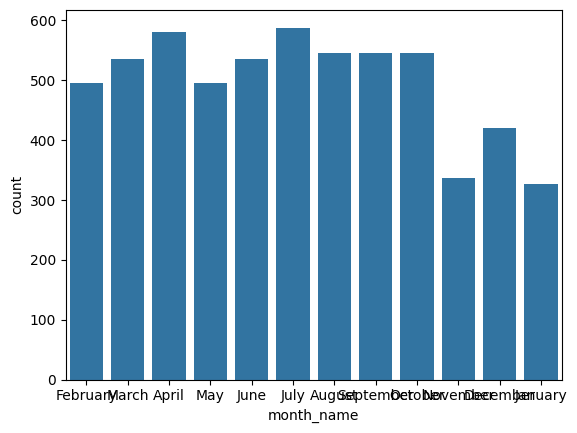

In [28]:
sns.countplot(data=df,x="month_name");

In [29]:
df_copy = df.copy()

In [30]:
df_copy.drop(['date', 'year', 'month'], axis = 1, inplace = True)

- we will leave only number of week as we forecast weekly_sales
- also, as the data is seasonal, we need to consider months of sales


In [31]:
df_copy

,store,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment,week,month_name
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,5,February
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,6,February
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,7,February
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,8,February
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,9,March
...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,39,September
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,40,October
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,41,October
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,42,October


In [32]:
# the next step is to normalise our data. it's important as it needs to be scalable
df_copy['store'] = df_copy['store'].astype('object')
df_copy['holiday_flag'] = df_copy['holiday_flag'].astype('object')
df_copy['week'] = df_copy['week'].astype('object')

In [33]:
from  sklearn.model_selection import train_test_split

# but before normalizing the data it needs to be splitted
X=df_copy.drop("weekly_sales",axis=1)
y=df_copy["weekly_sales"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [34]:
num_features=df_copy.select_dtypes('number').columns.to_list()
num_features.remove("weekly_sales")

cat_features=df_copy.select_dtypes('object').columns.to_list()

print(num_features)
print(cat_features)

['temperature', 'fuel_price', 'cpi', 'unemployment']
['store', 'holiday_flag', 'week', 'month_name']


In [35]:
transformer=ColumnTransformer([
                              ('num_features',StandardScaler(),num_features),
                              ('cat_features',BinaryEncoder(),cat_features),
])


transformer.fit(X_train)

ColumnTransformer(transformers=[('num_features', StandardScaler(),
                                 ['temperature', 'fuel_price', 'cpi',
                                  'unemployment']),
                                ('cat_features', BinaryEncoder(),
                                 ['store', 'holiday_flag', 'week',
                                  'month_name'])])

In [36]:
# transform for train and test
X_train_transformed = transformer.transform(X_train)
#X_test_transformed = transformer.transform(X_test)

In [37]:
num_features=X_test.select_dtypes('number').columns.to_list()
cat_features=X_test.select_dtypes('object').columns.to_list()
transformer=ColumnTransformer([
                              ('num_features',StandardScaler(),num_features),
                              ('cat_features',BinaryEncoder(),cat_features),
])


transformer.fit(X_train)
X_test_transformed = transformer.transform(X_test)

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [39]:
Lr=LinearRegression()
Lr.fit(X_train_transformed,y_train)

LinearRegression()

In [40]:
def performance(estimator, Training_Testing, X, y):
  predict_data = estimator.predict(X)
  print(f'RMSE: {round(np.sqrt(mean_squared_error(y, predict_data)), 2)}')
  print(f'R2: {round(r2_score(y, predict_data) * 100, 2)}')

In [41]:
performance(Lr, 'Training', X_train_transformed, y_train)

RMSE: 537565.61
R2: 10.2


In [42]:
def tuning(estimator, X_train, y_train, param_grid, score = 'r2', n = 5):
  # USE GridSearch to find the best params
  grid_search = GridSearchCV(estimator = estimator,
                               param_grid = param_grid,
                               scoring = score,
                               cv = n)

  grid_search.fit(X_train,y_train)

  best_params = grid_search.best_params_
  best_score = grid_search.best_score_

  print(f'Best params: {best_params} \n')
  print(f'Best score: {best_score}')

  best_estimator = grid_search.best_estimator_
  return best_estimator

In [66]:
# Polynomial Regression Model
LR_pipe = Pipeline([('poly_feat', PolynomialFeatures()),
                    ('lin_reg', LinearRegression())])

param_grid = {'poly_feat__degree': [2, 3, 4]}

best_estimator = tuning(LR_pipe, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best params: {'poly_feat__degree': 3} 

Best score: 0.9561234182675733


In [67]:
poly_reg = best_estimator

In [68]:
# Training Accuracy Afer tuning
performance(poly_reg, 'Training', X_train_transformed, y_train)

RMSE: 73899.37
R2: 98.3


In [69]:
def Distribution_Plot(estimator, Training_Testing, X, y, Title):
    y_pred = estimator.predict(X)

    ax1 = sns.distplot(y, hist = False, color = "b", label = f'Actual Values ({Training_Testing})')
    ax2 = sns.distplot(y_pred, hist = False, color = "r", label = f'Predicted Values ({Training_Testing})', ax = ax1)
    plt.title(Title, size = 18)
    plt.legend()
    plt.show()

<ipython-input-69-f8c85d175ad3>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y, hist = False, color = "b", label = f'Actual Values ({Training_Testing})')
<ipython-input-69-f8c85d175ad3>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.distplot(y_pred, hist = False, color

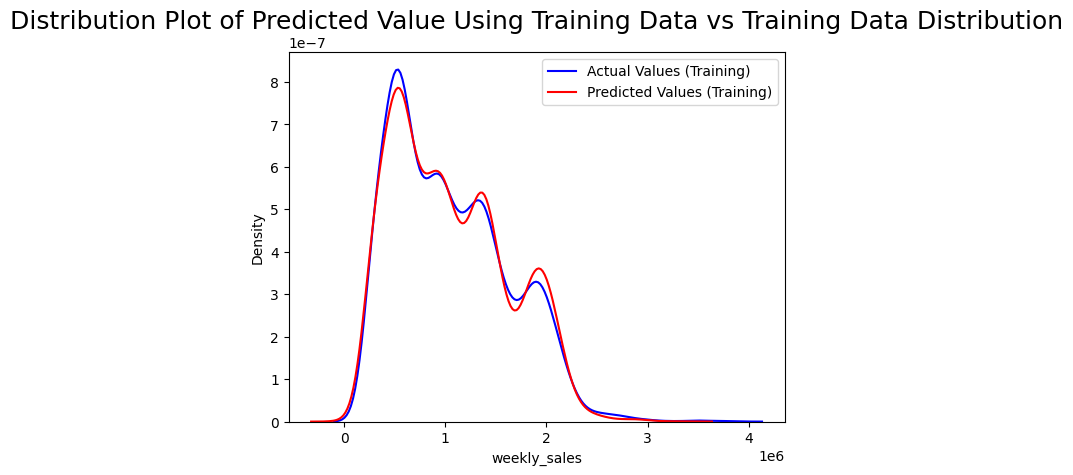

In [70]:
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(poly_reg, 'Training', X_train_transformed, y_train, Title)

In [71]:
performance(poly_reg,'Testing',X_test_transformed,y_test)

RMSE: 116417.07
R2: 96.13


<ipython-input-69-f8c85d175ad3>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y, hist = False, color = "b", label = f'Actual Values ({Training_Testing})')
<ipython-input-69-f8c85d175ad3>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.distplot(y_pred, hist = False, color

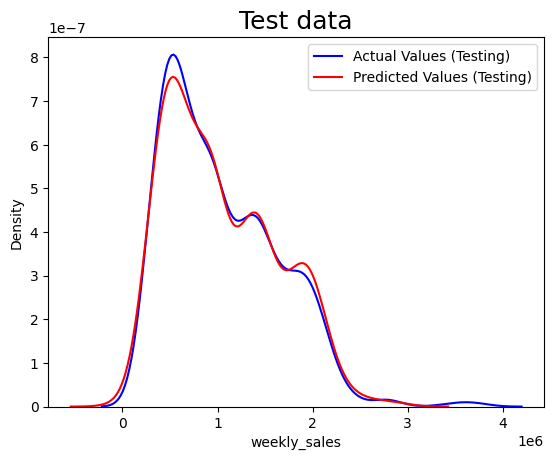

In [72]:
Title='Test data'
Distribution_Plot(poly_reg, 'Testing', X_test_transformed, y_test, Title)

In [73]:
Dt=DecisionTreeRegressor()
Dt.fit(X_train_transformed,y_train)

DecisionTreeRegressor()

In [74]:
performance(Dt,'Trainig',X_train_transformed,y_train)

RMSE: 0.0
R2: 100.0


<ipython-input-69-f8c85d175ad3>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y, hist = False, color = "b", label = f'Actual Values ({Training_Testing})')
<ipython-input-69-f8c85d175ad3>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.distplot(y_pred, hist = False, color

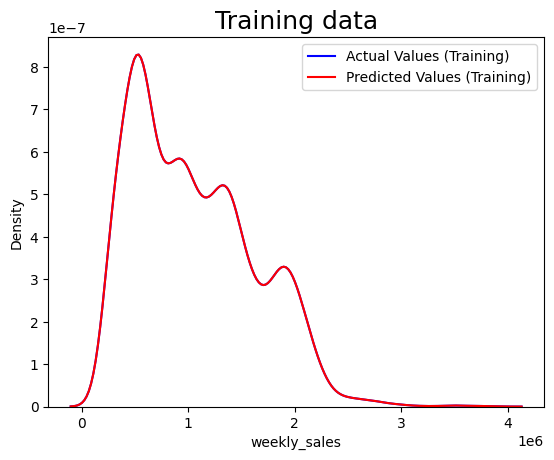

In [75]:
Title = 'Training data'
Distribution_Plot(Dt, 'Training', X_train_transformed, y_train, Title)

In [76]:
param_grid={'max_depth':np.arange(2,15),
            'min_samples_split': [10, 20, 30, 40, 50, 100, 200, 300]}

best_estimator = tuning(Dt, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best_Tree = best_estimator

Best params: {'max_depth': 12, 'min_samples_split': 40} 

Best score: 0.91642318807738


In [77]:
performance(Best_Tree,'Training',X_test_transformed,y_test)

RMSE: 170943.63
R2: 91.65


<ipython-input-69-f8c85d175ad3>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y, hist = False, color = "b", label = f'Actual Values ({Training_Testing})')
<ipython-input-69-f8c85d175ad3>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.distplot(y_pred, hist = False, color

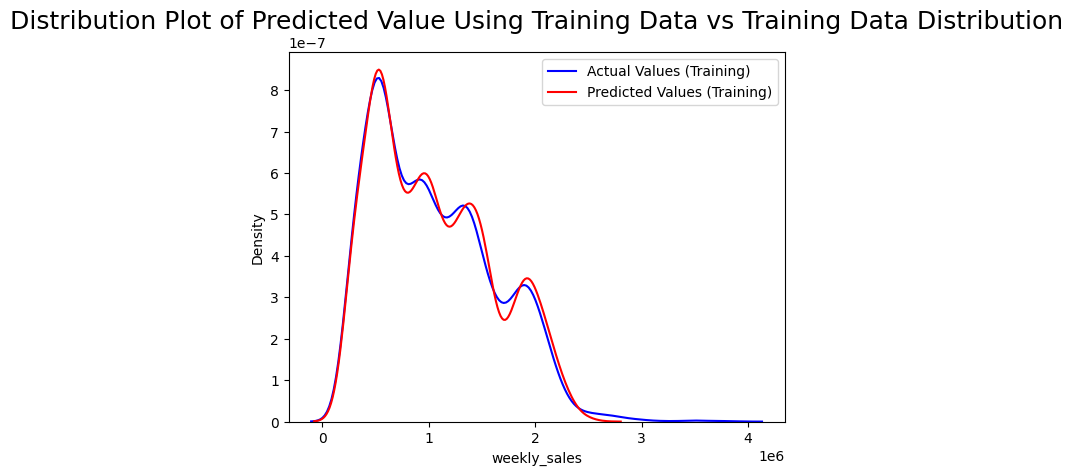

In [78]:

Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(Best_Tree, 'Training', X_train_transformed, y_train, Title)

In [79]:
performance(Best_Tree, 'Testing', X_test_transformed, y_test)

RMSE: 170943.63
R2: 91.65


<ipython-input-69-f8c85d175ad3>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(y, hist = False, color = "b", label = f'Actual Values ({Training_Testing})')
<ipython-input-69-f8c85d175ad3>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax2 = sns.distplot(y_pred, hist = False, color

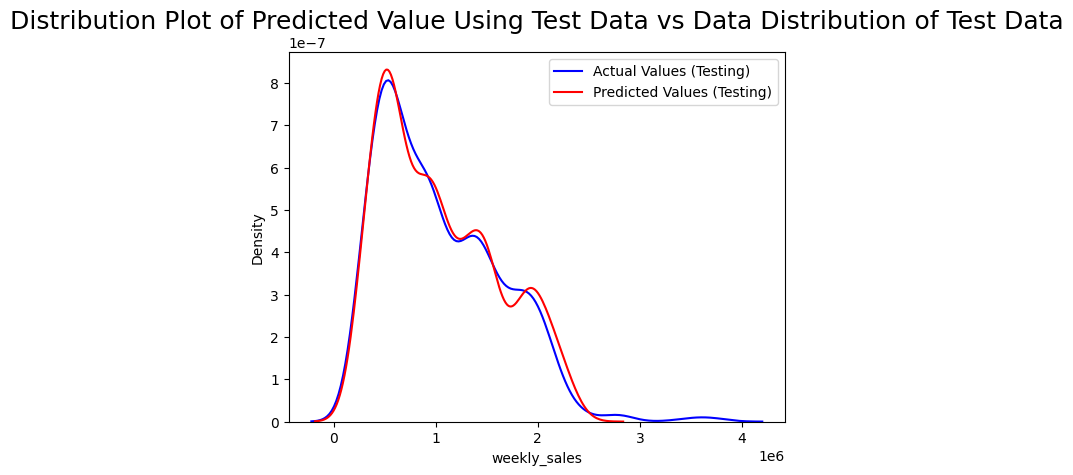

In [80]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(Best_Tree, 'Testing', X_test_transformed, y_test, Title)